# CSI4142 - Group 48 - Assignment 4

---
#### Group 48 Members  
- Ali Bhangu - 300234254
- Justin Wang - 300234186
---

## Introduction
Welcome to Group 48's Assignment 4 Jupyter Notebook. Within this file, please find 4 studies & a Data Preperation step prior to the studies:

#### Table of Contents
1. Data Preparation  
2. Study 1: Similarity Measures  
    - Programmed Similarity Measures
3. Study 2: Clustering  
    - Used Clustering Algorithms
4. Study 3: Content-Based Filtering  
    - Developed Similarity Heuristics & Developed Content-Based Filtering
5. Study 4: Collaborative Filtering  
    - Developed an R Matrix & Utilized Matrix Factorization 
6. Conclusion & References

Within each study, we have included our analysis on our findings, be it graphs or statistics.  In the following section, you will find first pip3 terminal commands installing the required packages we needed, followed by our import statements. Then you will find the Dataset Description along with a function that is using **Kaggle C-URL** to download, unzip, and load the CSVs used. 


<br>

---

In [4]:
!pip3 install Levenshtein
!pip3 install numpy
!pip3 install pandas
!pip3 install kaggle
!pip3 install fuzzywuzzy
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install scikit-learn

In [57]:
# Importing the required Python libraries
import numpy as npy
import pandas as pd
from fuzzywuzzy import fuzz
from sklearn.metrics import accuracy_score
import os as os
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cityblock
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import Levenshtein
import re
import ast
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

For this assignment, we have chosen to utilize the Movies Metadata Dataset, as we felt it was the most intriguing of the options provided to us. 

### Movies Metadata Dataset (Used for Studies 1,2,3)

- **Rows:** 45,466  
- **Columns:** 24  
- **Author:** Rounak Banik (Kaggle)
- **Purpose:** Provides extensive metadata for thousands of movies, used in recommendation systems and movie analytics.

#### Key Features

| Feature Name              | Data Type | Description |
|---------------------------|-----------|-------------|
| `id`, `imdb_id`           | Object    | Movie identifiers (some `id` values are non-numeric). |
| `title`, `original_title` | Object    | Movie title in English and original language. |
| `genres`                  | Object    | List of genres (stored as stringified dictionaries). |
| `release_date`            | Object    | Movie release date (some missing). |
| `budget`, `revenue`       | Object / Float | Budget and box office revenue (many zero values). |
| `runtime`                 | Float     | Duration of the movie in minutes. |
| `vote_average`, `vote_count` | Float | Viewer rating and total votes. |
| `popularity`              | Object    | Numeric popularity score stored as string. |
| `tagline`, `overview`     | Object    | Short slogan and movie synopsis. |
| `production_companies`, `production_countries` | Object | Nested JSON-like fields as strings. |

<br>

---

<br>

### Ratings_Small Dataset (Used for Study 4)

- **Rows:** 100,004  
- **Columns:** 4  
- **Author:** Same as above. 
- **Purpose:** Captures user-generated movie ratings for recommendation tasks.

#### Key Features

| Feature Name | Data Type | Description |
|--------------|-----------|-------------|
| `userId`     | Int64     | Unique ID of the user. |
| `movieId`    | Int64     | Foreign key referencing `movies_metadata['id']`. |
| `rating`     | Float64   | Movie rating from 0.5 to 5.0. |
| `timestamp`  | Int64     | UNIX timestamp of when the rating was given. |

<br>

---


In [3]:
# Function to Unzip and Extract The Ideal Files

# Define paths
zip_path = "the-movies-dataset.zip"
target_csv = "movies_metadata.csv"  # The main CSV we want to keep
unwanted_csvs = ["keywords.csv", "credits.csv", "links.csv", "links_small.csv", "ratings.csv"]  # Unwanted files

# Remove existing files if present
if os.path.exists(target_csv):
    print(f"Existing {target_csv} found. Deleting and re-extracting...")
    os.remove(target_csv)

# Download dataset using curl (Bash command in Jupyter Notebook)
!curl -L -o {zip_path} https://www.kaggle.com/api/v1/datasets/download/rounakbanik/the-movies-dataset

# Extract the ZIP file in the current folder
print("Extracting dataset...")
!unzip -o {zip_path} -d .

# Delete unwanted CSV files
for file in unwanted_csvs:
    if os.path.exists(file):
        os.remove(file)
        print(f"Deleted unwanted file: {file}")

# Verify that the target CSV exists after extraction
if not os.path.exists(target_csv):
    raise FileNotFoundError(f"Dataset not found: {target_csv}. Ensure the ZIP file was correctly extracted.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  227M  100  227M    0     0  8048k      0  0:00:28  0:00:28 --:--:-- 18.5M
Extracting dataset...
Archive:  the-movies-dataset.zip
  inflating: ./credits.csv           
  inflating: ./keywords.csv          
  inflating: ./links.csv             
  inflating: ./links_small.csv       
  inflating: ./movies_metadata.csv   
  inflating: ./ratings.csv           
  inflating: ./ratings_small.csv     
Deleted unwanted file: keywords.csv
Deleted unwanted file: credits.csv
Deleted unwanted file: links.csv
Deleted unwanted file: links_small.csv
Deleted unwanted file: ratings.csv


In [45]:
movieSet = pd.read_csv(target_csv)
print("Dataset loaded successfully.")

movieSet.head()
movieSet.info()

Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45

/var/folders/_m/4sf1w9m55kvg_9h80xcfx9_r0000gn/T/ipykernel_6687/621069896.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movieSet = pd.read_csv(target_csv)


---
# Data Preperation 

### 1. Data Cleaning: 

Within this section, we will be running 3 tests to analyze and assess our data. We have chosen to run a presence check, an exact-duplicate check, and a format check. Followed by outlier detection, with a function to replace the outliers with their mean imputated values. 

#### Exact Duplcate Check:

After validating the presence check for the attributes we deemed critical, we replaced the missing values in revenue and runtime with their respective mean values via mean imputation and utilized an Abritrary Value of 2000-01-01 (Janaury 1st, 2000) for the missing release dates. 



Now, we are opting to run an exact duplicate check on our dataset, to remove any discrepancies and accidentally duplicated data within the dataframe. 

In [46]:
# Exact Duplicate Checker: 
movieSet.info()

movieSet2 = movieSet.copy()

# Function to check for exact duplicates, dropping the duplicates and keeping the first instance and ensuring the index is reset.
movieSet = movieSet.drop_duplicates(keep="first").reset_index(drop=True)
print("Duplicates removed successfully.")

# Checking the new dataset
movieSet.head() 
movieSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

#### Presence Checker:

After running the Exact Duplicate Check, we have opted to run a Presence Check via a modified and enhanced version of our presence checker from Assignment 2 & Assignment 3. We plan to replace missing values in the key attributes with either their mean value, via mean imputation, or via arbitrary values, such as for release date, we will utilize a value of 2000-01-01 (January 1st, 2000) for the missing release dates. 

In [47]:
def presence_checker(df, columns=["genres", "budget", "original_title", "release_date", "revenue", "runtime"]):
    # Filter DataFrame to only check the specified columns
    selected_df = df[columns]
    
    # Count missing values in selected columns
    missing_counts = selected_df.isna().sum()
    
    # Filter to only columns that have missing values
    missing_summary = missing_counts[missing_counts > 0]
    
    if missing_summary.empty:
        print("No missing values found in the specified columns.")
    else:
        print("Missing values detected in the following columns:\n")
        for column, count in missing_summary.items():
            print(f"Column '{column}': {count} missing values")
            print(df[df[column].isna()][[column]].head(min(5, count)))  # Show up to 5 examples
            print("\n" + "-"*50 + "\n")
    
    return missing_summary

presence_checker(movieSet)


Missing values detected in the following columns:

Column 'release_date': 87 missing values
     release_date
711           NaN
734           NaN
3459          NaN
3627          NaN
5878          NaN

--------------------------------------------------

Column 'revenue': 6 missing values
       revenue
19724      NaN
19725      NaN
29490      NaN
29491      NaN
35574      NaN

--------------------------------------------------

Column 'runtime': 263 missing values
     runtime
634      NaN
635      NaN
644      NaN
802      NaN
863      NaN

--------------------------------------------------



release_date     87
revenue           6
runtime         263
dtype: int64

With the missing values we have found after our check, we decided to replace the numerical categories missing values with their mean and for the release-date attribute, we have opted on using Arbitrary Values to input 2000-01-01 for the missing release dates. 

In [48]:
# Mean Imputation 
def fill_na_with_mean(df, target_column):
    mean_value = df[target_column].mean()  # Calculate mean of the column
    df[target_column] = df[target_column].fillna(mean_value)  # Replace NaNs with mean
    return df

fill_na_with_mean(movieSet, "runtime")
presence_checker(movieSet, ["runtime"])

fill_na_with_mean(movieSet, "revenue")
presence_checker(movieSet, ["revenue"])

# Replace NaN values in 'release_date' with "2000-01-01"
movieSet['release_date'] = movieSet['release_date'].fillna("2000-01-01")

# Arbitrary Value Filled: 
missing_release_date = movieSet['release_date'].isna().sum()
print(missing_release_date)

fill_na_with_mean(movieSet2, "runtime")
presence_checker(movieSet2, ["runtime"])

fill_na_with_mean(movieSet2, "revenue")
presence_checker(movieSet2, ["revenue"])

# Replace NaN values in 'release_date' with "2000-01-01"
movieSet2['release_date'] = movieSet2['release_date'].fillna("2000-01-01")


No missing values found in the specified columns.
No missing values found in the specified columns.
0
No missing values found in the specified columns.
No missing values found in the specified columns.


#### Format Checker
For our last portion of the data cleaning, we have opted to utilize our Format Checker from Assignment 2, we have decided to run it on the release_date column as the format is in the regex pattern of `pattern = r'^\d{4}-\d{2}-\d{2}$'`

In [8]:
# Column we are checking: 
column = 'release_date'
# Please enter the regex pattern you would like to check for
pattern = r'^\d{4}-\d{2}-\d{2}$'

# Format Check Test: 
def format_checker(df, column, pattern):
    # creating the regex pattern
    regex = re.compile(pattern)
    
    # Applying the regex pattern to the column and filters the rows that don't match
    mismatched_rows = df[~df[column].astype(str).apply(lambda x: bool(regex.match(x)))]
    total_mismatched = mismatched_rows.shape[0]
    
    # Printing the results of the format check. 
    print(f"There are {total_mismatched} data points in {column} that do not match the format {pattern}. \nSee below for examples if there are mismatched rows:")
    
    # Outputting the mismatched rows for the user to see
    if total_mismatched > 0:
        print("\nHere are some of the rows of mismatched format:")
        print(mismatched_rows.head(3))  

# Running the function with parameters defined above:
format_checker(movieSet, column, pattern)

There are 3 data points in release_date that do not match the format ^\d{4}-\d{2}-\d{2}$. 
See below for examples if there are mismatched rows:

Here are some of the rows of mismatched format:
                                                   adult  \
19725                                 - Written by Ørnås   
29491   Rune Balot goes to a casino connected to the ...   
35575   Avalanche Sharks tells the story of a bikini ...   

      belongs_to_collection                            budget  \
19725              0.065736  /ff9qCepilowshEtG2GYWwzt2bs4.jpg   
29491              1.931659  /zV8bHuSL6WXoD6FWogP9j4x80bL.jpg   
35575              2.185485  /zaSf5OG7V8X8gqFvly88zDdRm46.jpg   

                                                  genres  \
19725  [{'name': 'Carousel Productions', 'id': 11176}...   
29491  [{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...   
35575  [{'name': 'Odyssey Media', 'id': 17161}, {'nam...   

                                                homepage        

#### Formatting Genres

We have opted to format genres in an acceptable way instead of as they are currently outputted. We are using Python's built-in Abstract Syntax Tree list into our program to utilize. This way we have our genres formatted in a manner that we can utilize in our studies. 

In [49]:
def clean_genres(df, column):
    df[column] = df[column].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
    df[column] = df[column].apply(lambda x: [genre['name'] for genre in x] if isinstance(x, list) else [])
    return df

clean_genres(movieSet, "genres")
movieSet.head()

clean_genres(movieSet2, "genres")


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[Drama, Family]",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,2000-01-01,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,[Drama],NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[Action, Drama, Thriller]",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


---
### 2. Exploratory Data Analysis

Within this section, we are using Seaborn and MatplotLib to conduct exploratory data analysis to explore if there is any correlation between attributes within our data set. 

This scatter plot visualizes the relationship between a movie's production budget and its revenue. Since both are continuous numerical features included in the dataset, this plot helps us identify the spread and correlation of these two dimensions.  The plot also highlights data skew, potential outliers (e.g., extreme blockbusters), and whether high budgets generally lead to high revenue—insights that can influence our feature selection and scaling strategies later in the assignment.


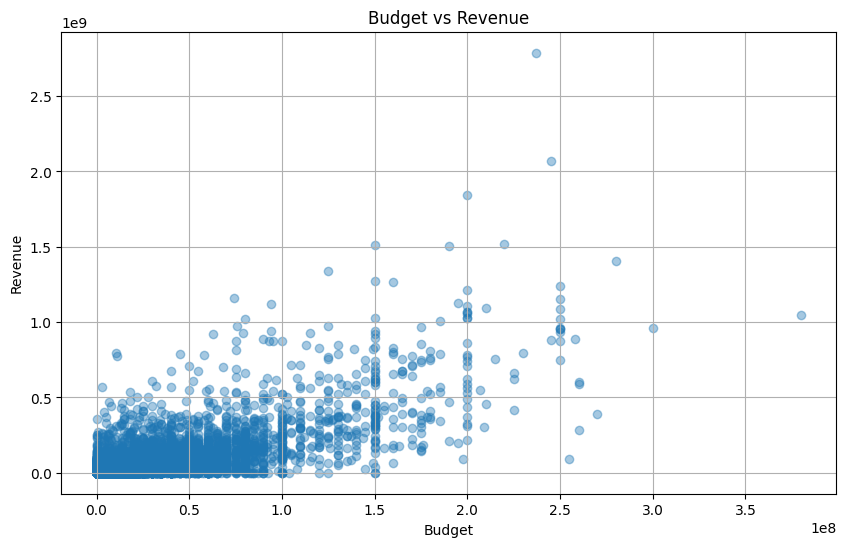

In [10]:
# Ensure 'budget' contains only numeric values and replace invalid entries
movieSet['budget'] = pd.to_numeric(movieSet['budget'], errors='coerce')

# Replace NaN values (from bad data) with 0 or median budget
movieSet['budget'] = movieSet['budget'].fillna(movieSet['budget'].median())

# Convert back to integer for consistency
movieSet['budget'] = movieSet['budget'].astype(int)

# Plot Budget vs Revenue
plt.figure(figsize=(10, 6))
plt.scatter(movieSet['budget'], movieSet['revenue'], alpha=0.4)
plt.title("Budget vs Revenue")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()

We are conducting a top genre count for Jaccard Simularity Measures & Clustering, Study 1 and Study 3 respectively, this will assist us in choosing the most frequent genres to test for similarity. 

In [16]:
# Calculating the Top 10 Genres 
genre_list = [g for genres in movieSet['genres'] for g in genres]
genre_counts = Counter(genre_list)

# Convert the genre counts to a DataFrame for better visualization
genre_df = pd.DataFrame(genre_counts.most_common(10), columns=['Genre', 'Count'])
display(genre_df)


,Genre,Count
0,Drama,20255
1,Comedy,13180
2,Thriller,7621
3,Romance,6734
4,Action,6594
5,Horror,4672
6,Crime,4306
7,Documentary,3932
8,Adventure,3495
9,Science Fiction,3046


---
### Study 1 - Similarity Measures 

Within this section, we are conducting the following: 

1. Picking a subset of 5 attributes (e.g. Genre, Revenue, Runtime, Title, Budget) from our dataset. 
2. Simulating 5 Requests to show the results of our 5 similarity measures. 
3. For each request, show the Top 10 results (ranked on the criteria chosen). 

We have opted to utilize the following 5 attributes:
1. Budget
2. Genre
3. Runtime
4. Title 
5. Revenue

And the following Similarity Measures:
1. Jaccard
2. Euclidean 
3. Cosine 
4. Manhattan 
5. For Textual Data : Levenshtein Distance Operations

In [11]:
# Jaccard Distance Function: 
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

In [12]:
# Euclidean Distance Function: 

# Using the Scipy Library to calculate the distance between two points
def euclidean_distance(val1, val2):
    return euclidean([val1], [val2])

In [13]:
# Cosine Similarity Function:

# Using the SKLearn Library to calculate the cosine similarity between two points
def cosine_sim(val1, val2):
    return cosine_similarity([[val1]], [[val2]])[0][0] if val1 and val2 else 0

In [14]:
# Levenshtein Distance Function:

# Using the Levenshtein Library to calculate the distance between two strings
def edit_distance(title1, title2):
    return Levenshtein.distance(title1.lower(), title2.lower())

In [15]:
# Manhattan Distance Function: 
# Using the Scipy Library and the City Block function to calculate the distance between two points 
def manhattan_distance(val1, val2):
    return cityblock([val1], [val2])

### Function For Testing:

If higher_is_better = True:

The function sorts the results in descending order (from highest to lowest similarity score).
This is useful when using Jaccard Similarity or Cosine Similarity, where higher scores indicate greater similarity.
Example: Genre Similarity (Jaccard Score: 0.9 is better than 0.5).
If higher_is_better = False:

The function sorts the results in ascending order (from lowest to highest distance).
This is useful for distance-based measures like Euclidean or Manhattan Distance, where lower values indicate closer matches.
Example: Revenue Similarity (a difference of $10M is better than $500M).

In [16]:
def find_top_similar_movies(target_movie, column, similarity_func, higher_is_better=True):
    if target_movie not in movieSet['original_title'].values:
        return f"Movie '{target_movie}' not found in dataset."

    target_value = movieSet[movieSet['original_title'] == target_movie][column].values[0]

    similarities = []
    for _, row in movieSet.iterrows():
        if row['original_title'] != target_movie:
            # Ensure genres are converted to sets for Jaccard Similarity
            if column == "genres":
                similarity = similarity_func(set(target_value), set(row[column]))
            else:
                similarity = similarity_func(target_value, row[column])
            similarities.append((row['original_title'], float(similarity)))

    # Sort results
    sorted_results = sorted(similarities, key=lambda x: x[1], reverse=higher_is_better)

    # Return top 10 similar movies
    return sorted_results[:10]


In [17]:
# Running the function with the parameters here:
find_top_similar_movies("Titanic", "revenue", euclidean_distance, higher_is_better=False)

[('Star Wars: The Force Awakens', 223189436.0),
 ('The Avengers', 325476278.0),
 ('Jurassic World', 331505378.0),
 ('Furious 7', 338784828.0),
 ('Avengers: Age of Ultron', 439630494.0),
 ('Harry Potter and the Deathly Hallows: Part 2', 503034188.0),
 ('Frozen', 570815179.0),
 ('Beauty and the Beast', 582147851.0),
 ('The Fate of the Furious', 606269423.0),
 ('Iron Man 3', 629594194.0)]

In [18]:
# Running the function with the parameters here:
find_top_similar_movies("The Avengers", "genres", jaccard_similarity, higher_is_better=True)

[('The Tie That Binds', 1.0),
 ('Dream Man', 1.0),
 ('O Convento', 1.0),
 ('Baton Rouge', 1.0),
 ('The Innocent Sleep', 1.0),
 ('U Turn', 1.0),
 ('Stag', 1.0),
 ('Stranger in the House', 1.0),
 ('Hard Rain', 1.0),
 ('Wild Things', 1.0)]

In [19]:
movieSet['budget'] = movieSet['budget'].astype(int)

# Using cosine_sin function to find the top similar movies relating to budget for Interstellar
find_top_similar_movies("Interstellar", "budget", cosine_sim, higher_is_better=True)


[('Toy Story', 1.0),
 ('Jumanji', 1.0),
 ('Waiting to Exhale', 1.0),
 ('Heat', 1.0),
 ('Sabrina', 1.0),
 ('Sudden Death', 1.0),
 ('GoldenEye', 1.0),
 ('The American President', 1.0),
 ('Nixon', 1.0),
 ('Cutthroat Island', 1.0)]

In [20]:
# Using the Levenshtein Distance function to find the top similar movies relating to the title for The Dark Knight
find_top_similar_movies("The Dark Knight", "original_title", edit_distance, higher_is_better=False)


[('The Black Knight', 3.0),
 ('One Dark Night', 3.0),
 ('The Dark Angel', 4.0),
 ('The Good Night', 5.0),
 ('The Long Night', 5.0),
 ('The Dark Wind', 5.0),
 ('Shark Night', 5.0),
 ('The Big Night', 5.0),
 ('The Dark Past', 5.0),
 ('The Last Flight', 5.0)]

In [21]:
# Using the Euclidean Distance function to find the top similar movies relating to the revenue for Avatar
find_top_similar_movies("Avatar", "revenue", euclidean_distance, higher_is_better=False)

[('Star Wars: The Force Awakens', 719741463.0),
 ('Titanic', 942930899.0),
 ('The Avengers', 1268407177.0),
 ('Jurassic World', 1274436277.0),
 ('Furious 7', 1281715727.0),
 ('Avengers: Age of Ultron', 1382561393.0),
 ('Harry Potter and the Deathly Hallows: Part 2', 1445965087.0),
 ('Frozen', 1513746078.0),
 ('Beauty and the Beast', 1525078750.0),
 ('The Fate of the Furious', 1549200322.0)]

In [22]:
# Using the Manhattan Distance function to find the top similar movies relating to the runtime for The Matrix
# Outputs 0 indicates exact match of runtime
find_top_similar_movies("The Matrix", "runtime", manhattan_distance, higher_is_better=False)

[('Sense and Sensibility', 0.0),
 ('The Rock', 0.0),
 ('North by Northwest', 0.0),
 ('A Clockwork Orange', 0.0),
 ('Shall we ダンス?', 0.0),
 ('Seven Years in Tibet', 0.0),
 ('He Got Game', 0.0),
 ('The Mask of Zorro', 0.0),
 ("Rosemary's Baby", 0.0),
 ('Star Wars: Episode I - The Phantom Menace', 0.0)]

---
## Study 2: Clustering Algorithms 

In this study, I explored two clustering algorithms: KMeans and DBSCAN. Both algorithms were applied to two feature pairs: Budget vs Revenue and Runtime vs Budget. For KMeans, we tested multiple values of `k` (3, 4, and 5) to observe how the number of clusters impacts the grouping of movies. For DBSCAN, we experimented with different combinations of `eps` (0.5, 1.0, 1.5) and `min_samples` (5, 10, 15) to analyze its sensitivity to density-based clustering.

The visual inspection of the results revealed that KMeans performed well in creating distinct clusters for Budget vs Revenue, especially for average-budget movies. However, it struggled with outliers, such as blockbuster films, due to its assumption of spherical clusters. On the other hand, DBSCAN excelled at identifying outliers and forming clusters of varying shapes, particularly for Runtime vs Budget, where it captured dense regions effectively.

Based on my observations, KMeans is more suitable for datasets with well-separated, symmetric clusters, while DBSCAN is better for handling noise and irregularly shaped clusters. Both algorithms provided valuable insights, and their effectiveness depended on the feature pair and the nature of the data.

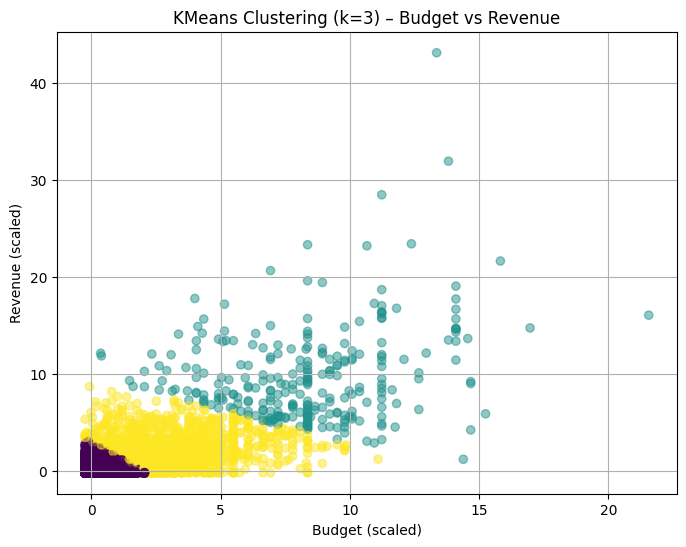

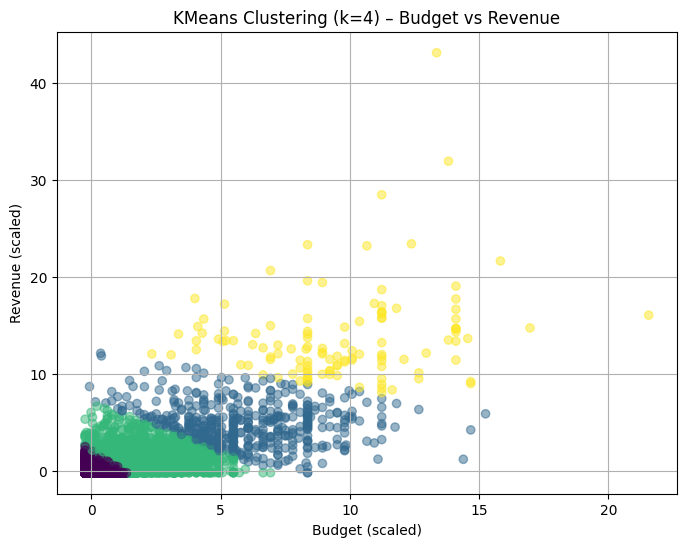

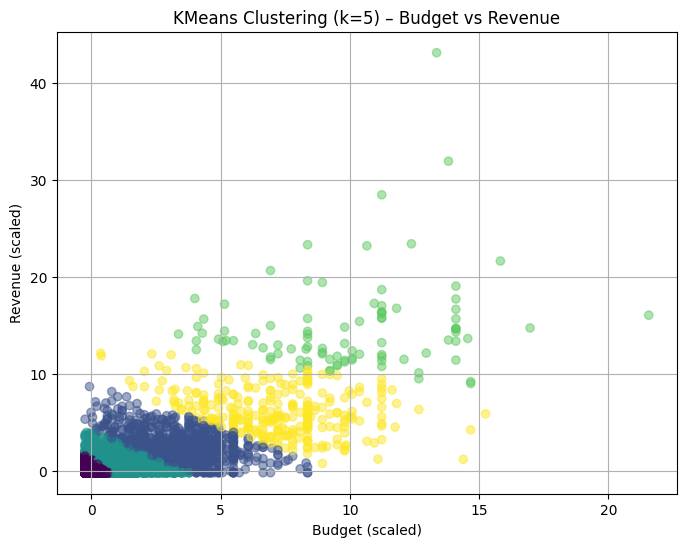

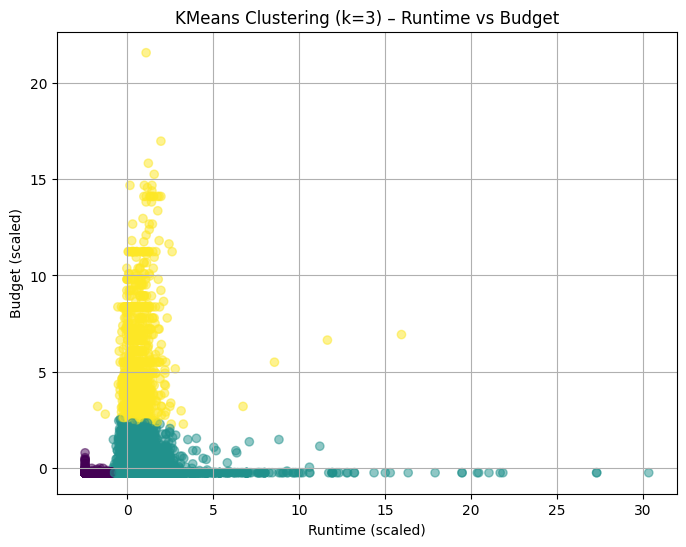

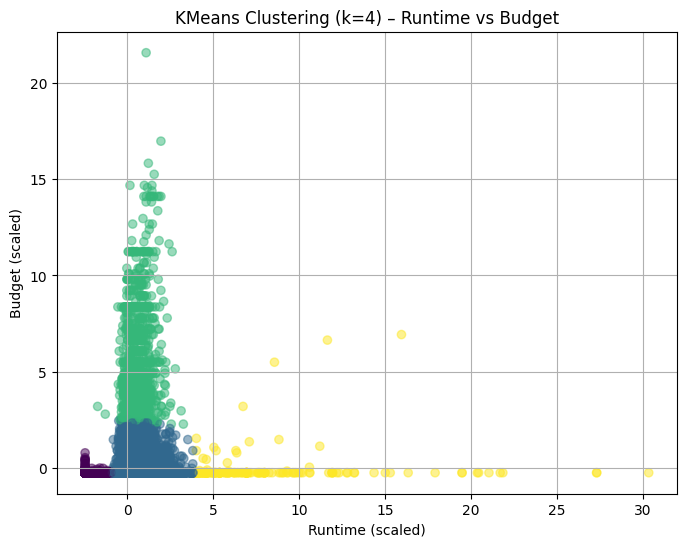

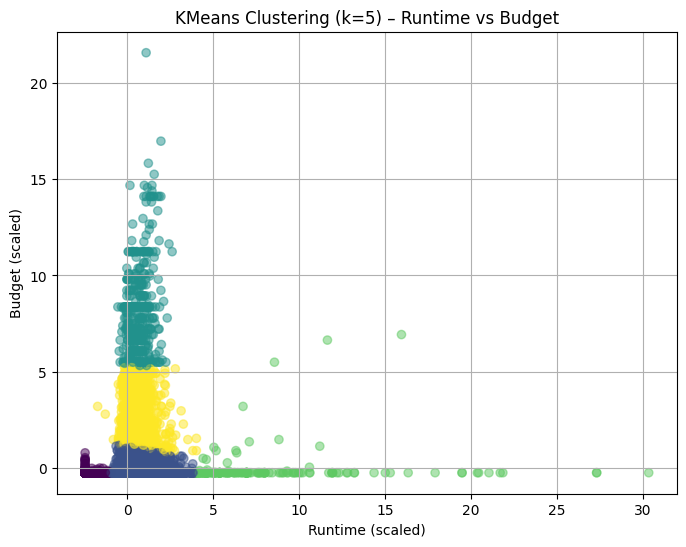

In [23]:
# Creating a combo with two different combinations of two attributes. 
X1 = movieSet[['budget', 'revenue']].copy()
X2 = movieSet[['runtime', 'budget']].copy()

# Standardize both so its good to use
X1_scaled = StandardScaler().fit_transform(X1)
X2_scaled = StandardScaler().fit_transform(X2)

# Lil bit of formatting to make it easier to access results. 
feature_sets = {
    "Budget vs Revenue": X1_scaled,
    "Runtime vs Budget": X2_scaled
}

# Loop through each feature pair
for name, data in feature_sets.items():
    for k in [3, 4, 5]:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(data)
        labels = kmeans.labels_

        plt.figure(figsize=(8, 6))
        plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.5)
        plt.title(f'KMeans Clustering (k={k}) – {name}')
        plt.xlabel(f"{name.split(' vs ')[0]} (scaled)")
        plt.ylabel(f"{name.split(' vs ')[1]} (scaled)")
        plt.grid(True)
        plt.show()

### Analyzing The Results from K-Means

We applied the KMeans clustering algorithm to two feature pairs: Budget vs Revenue and  Runtime vs Budget , using three values for `k`:  3, 4, and 5 . This allowed us to observe the impact of changing the number of clusters on the separation of movie data.

---
#### 1. Budget vs Revenue

This feature pairing provides insights into financial performance trends based on production investment.

#### k = 3
- A dominant cluster captures the majority of moderate-budget, moderate-revenue films.
- Two additional clusters represent:
  - High-budget films with varying levels of commercial success.
  - Low-revenue or near-zero return entries, potentially shorts or failed releases.

#### k = 4
- A distinct cluster of high-budget, high-revenue films emerges, separating blockbusters from general productions.
- Additional segmentation reveals more nuanced groups, including high-budget underperformers.

#### k = 5
- Further subdivisions isolate a small group of exceptionally high-revenue films.
- The resulting clusters, however, begin to lose interpretability, suggesting diminishing returns with additional clusters.

Summary:  
Clustering with **k = 4** provides a well-balanced segmentation of financial performance. Beyond this, the clusters may reflect noise or anomalies rather than meaningful groupings.

---
#### 2. Runtime vs Budget

This feature pair highlights patterns in production length and resource allocation.

#### k = 3
- A central cluster captures standard-length, mid-budget films.
- Outliers, such as very short or long productions, are grouped into separate clusters.

#### k = 4
- A more distinct high-budget cluster emerges, corresponding to feature-length productions.
- The model better differentiates between short films and full-length features.

#### k = 5
- Increased granularity identifies subgroups within long or short productions.
- Clusters begin to fragment and lose practical interpretability.

Summary:
Clustering with **k = 4** reveals meaningful distinctions between production types. Increasing to **k = 5** introduces potential overfitting without significant insight gain.

---
Conclusion:
The optimal cluster count appears to be **k = 4** for both feature pairings, providing interpretable and relevant segmentation. KMeans assumptions (e.g., equal variance, spherical clusters) limit its flexibility in datasets with high variance or non-convex shapes. Future work could benefit from integrating additional categorical features (e.g., genre, language) or adopting density-based clustering methods (e.g., DBSCAN) to capture more complex relationships.

---


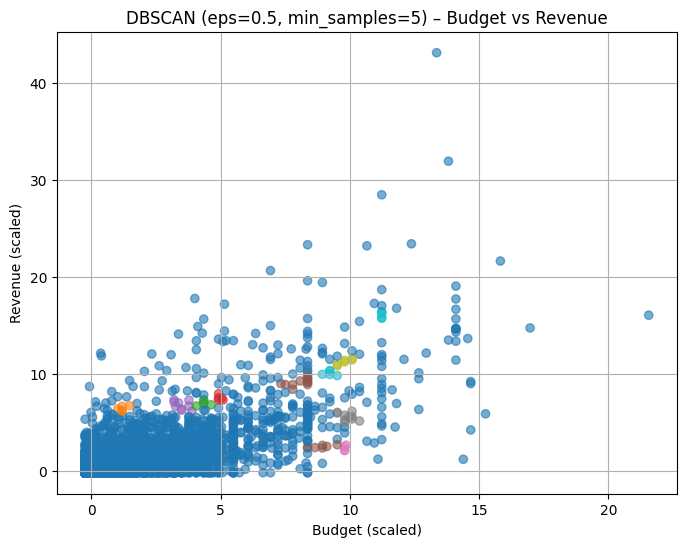

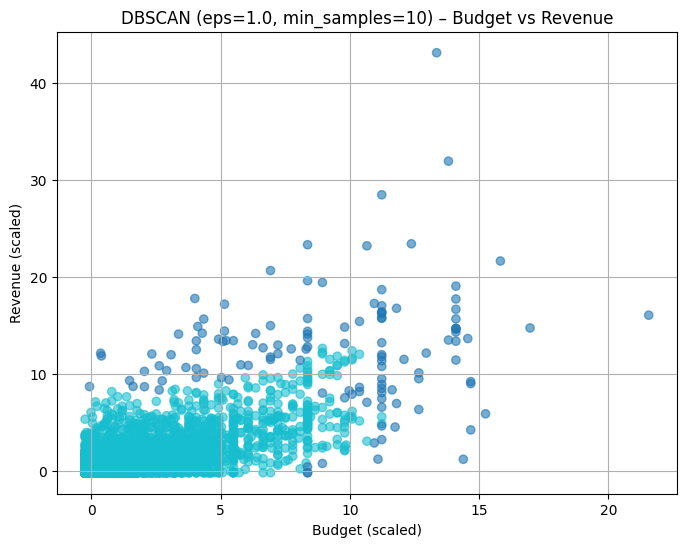

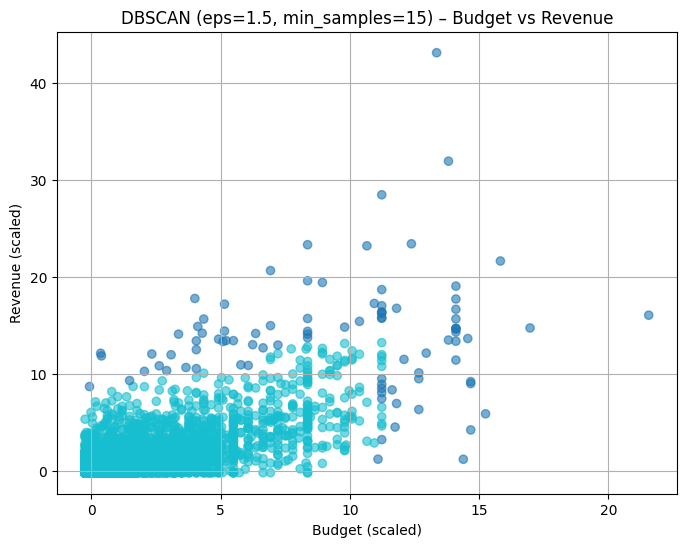

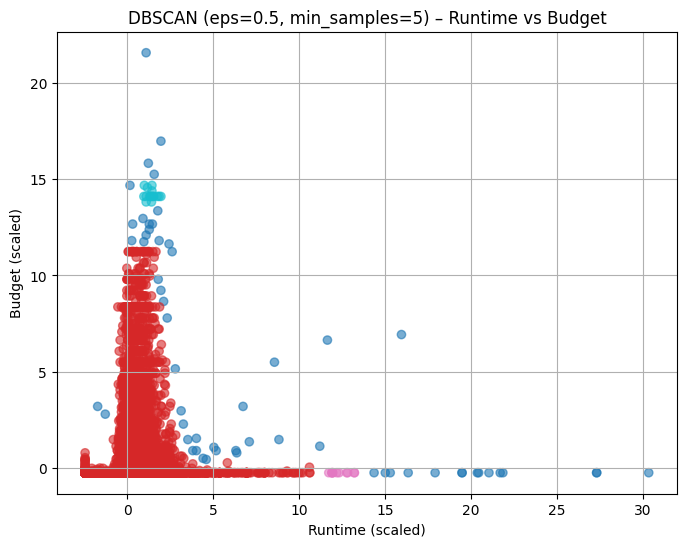

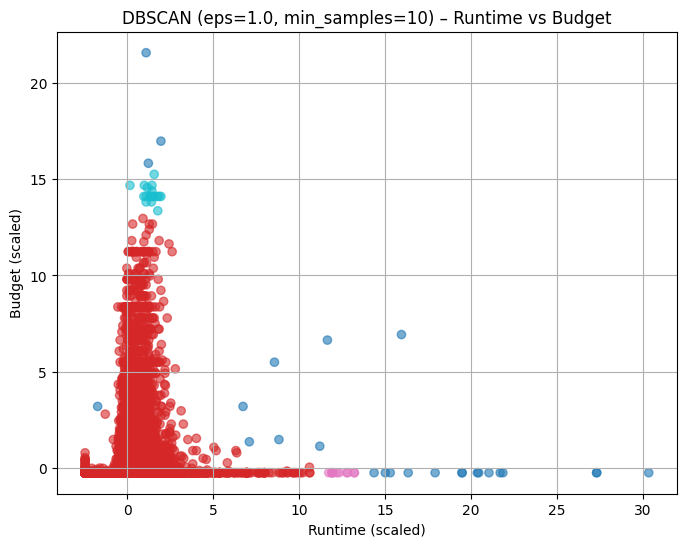

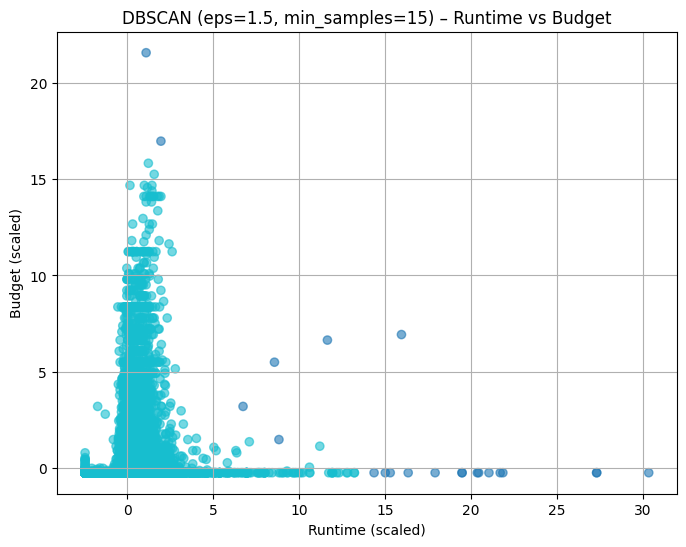

In [24]:
# Loop over feature sets and DBSCAN parameters
for name, data in feature_sets.items():
    for eps, min_samples in [(0.5, 5), (1.0, 10), (1.5, 15)]:
        try:
            db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
            labels = db.labels_

            # Check if all points are labeled as noise (-1)
            if len(set(labels)) <= 1:
                print(f"DBSCAN resulted in all noise or a single cluster for eps={eps}, min_samples={min_samples} on {name}. Skipping plot.")
                continue

            plt.figure(figsize=(8, 6))
            plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', alpha=0.6)
            plt.title(f'DBSCAN (eps={eps}, min_samples={min_samples}) – {name}')
            plt.xlabel(f"{name.split(' vs ')[0]} (scaled)")
            plt.ylabel(f"{name.split(' vs ')[1]} (scaled)")
            plt.grid(True)
            plt.show()
        except Exception as e:
            print(f"Error for DBSCAN with eps={eps}, min_samples={min_samples} on {name}: {e}")

### Analyzing the DBSCAN Results
We applied the DBSCAN clustering algorithm to two feature pairs: Budget vs Revenue and Runtime vs Budget, experimenting with different values for eps of (0.5, 1.0, 1.5) and min_samples of (5, 10, 15). The results revealed interesting insights into the strengths and limitations of DBSCAN for this dataset.

__Budget vs Revenue__:
- eps = 0.5: A significant portion of the data points were labeled as noise, highlighting the sensitivity of DBSCAN to the distance threshold. The clusters formed were sparse, and many blockbuster movies with extreme budget and revenue values were treated as outliers.
- eps = 1.0: Increasing the eps value allowed DBSCAN to capture broader clusters, effectively grouping mid-budget and mid-revenue movies. However, blockbuster-scale data points remained scattered, indicating the challenge of handling extreme outliers in this feature pair.
- eps = 1.5: With a higher eps, DBSCAN formed larger clusters, but the boundaries between clusters became less distinct. While this reduced the number of noise points, it also led to some overgeneralization, merging distinct groups into a single cluster.

__Runtime vs Budget__ :
- eps = 0.5: The algorithm identified a few dense clusters, primarily focusing on standard-length movies with mid-range budgets. Short and long runtime movies were often labeled as noise.
- eps = 1.0: This configuration provided a balanced clustering, effectively capturing dense regions while still distinguishing outliers. The clusters were more consistent compared to the Budget vs Revenue feature pair.
- eps = 1.5: Similar to the previous feature pair, increasing eps resulted in larger clusters with fewer noise points. However, the clusters remained meaningful, as Runtime vs Budget exhibited less variability compared to Budget vs Revenue.

__Key Observations__ : 
1. Sensitivity to eps: Lower eps values resulted in more noise points, while higher values reduced noise but risked merging distinct clusters.
2. Feature Pair Differences: Runtime vs Budget produced more consistent clusters due to the relatively uniform distribution of runtime and budget values. In contrast, Budget vs Revenue was heavily influenced by outliers, such as blockbuster movies with extreme values.
3. Outlier Handling: DBSCAN excelled at identifying outliers, particularly in the Budget vs Revenue feature pair, where extreme values were treated as noise.

#### Conclusion
DBSCAN proved to be a powerful tool for identifying dense regions and outliers in the dataset. For Budget vs Revenue, the algorithm struggled with the high variability and extreme outliers, but it performed well in capturing mid-range clusters. For Runtime vs Budget, DBSCAN provided more interpretable results, effectively grouping movies with similar production characteristics. Adjusting eps and min_samples allowed us to narrow the clustering, balancing noise reduction and cluster granularity.


---
## Study 3: Content Based Recommendation System 

Welcome to Study 3, the Content Based Recommendation System. 

Here we develop 2 similiarity heuristics each taking a subset of features, where a heuristic is defined as a domain informed strategy, like a combination. Our content-based recommendation system will use the heuristics to provide movie recommendations, we also will simulate a few requests to show the generated recommendations based on our 2 heuristics, with the top 10 results displayed. 

This is followed by a quick qualitative evaluation.

In [25]:
# Creating Our Heuristics: 
def heuristic_1(target, candidate):
    '''
    We are creating this heuristic to help us find the most similar movies to a target movie. 
    The heuristic will compare the genre, budget and revenue of the target movie with each candidate movie
    We also assigned weights to each of the features to reflect their importance with genre being 50%, budget 15% and revenue 35%
    '''
    genre_sim = jaccard_similarity(set(target['genres']), set(candidate['genres']))
    budget_sim = cosine_sim(target['budget'], candidate['budget'])
    revenue_sim = cosine_sim(target['revenue'], candidate['revenue'])
    return 0.5 * genre_sim + 0.15 * budget_sim + 0.35 * revenue_sim


def heuristic_2(target, candidate):
    '''
    This heuristic will compare the genre and runtime of the target movie with each candidate movie
    We decided to have this as our second heuristic such that we would beable to find similar films with the same pacing and vibe. 
    We also assigned weights to each of the features to reflect their importance with genre being 70% and runtime 30%
    '''
    genre_sim = jaccard_similarity(set(target['genres']), set(candidate['genres']))
    runtime_diff = abs(target['runtime'] - candidate['runtime'])
    max_runtime = movieSet['runtime'].max()
     # Normalizing the runtime score to be between [0,1]
    runtime_score = 1 - (runtime_diff / max_runtime) 
    return 0.7 * genre_sim + 0.3 * runtime_score

In [26]:
def recommend_movies_df(movie_title, heuristic_func, top_n=10):
    if movie_title not in movieSet['original_title'].values:
        return f"Movie '{movie_title}' not found in dataset."

    target_row = movieSet[movieSet['original_title'] == movie_title].iloc[0]
    results = []

    for _, row in movieSet.iterrows():
        if row['original_title'] == movie_title:
            continue
        score = heuristic_func(target_row, row)
        results.append({
            "Title": row['original_title'],
            "Score": round(score, 3),
            "Genres": row['genres'],
            "Runtime": row['runtime']
        })

    sorted_results = sorted(results, key=lambda x: x["Score"], reverse=True)
    return pd.DataFrame(sorted_results[:top_n])


In [28]:
test_movies = ["Toy Story 2", "The Matrix", "Fight Club"]

for movie in test_movies:
    print(f"\nRecommendations for: {movie} (Heuristic 1 - Genre + Budget + Revenue)\n")
    display(recommend_movies_df(movie, heuristic_1))

    print(f"\nRecommendations for: {movie} (Heuristic 2 - Genre + Runtime)\n")
    display(recommend_movies_df(movie, heuristic_2))



Recommendations for: Toy Story 2 (Heuristic 1 - Genre + Budget + Revenue)



,Title,Score,Genres,Runtime
0,Toy Story,1.0,"[Animation, Comedy, Family]",81.0
1,Oliver & Company,1.0,"[Animation, Comedy, Family]",74.0
2,Meet the Deedles,1.0,"[Animation, Comedy, Family]",93.0
3,The Great Mouse Detective,1.0,"[Comedy, Animation, Family]",74.0
4,Chicken Run,1.0,"[Animation, Comedy, Family]",84.0
5,"Monsters, Inc.",1.0,"[Animation, Comedy, Family]",92.0
6,Looney Tunes: Back in Action,1.0,"[Animation, Comedy, Family]",90.0
7,Garfield,1.0,"[Animation, Comedy, Family]",80.0
8,The SpongeBob SquarePants Movie,1.0,"[Animation, Comedy, Family]",87.0
9,Chicken Little,1.0,"[Animation, Family, Comedy]",81.0



Recommendations for: Toy Story 2 (Heuristic 2 - Genre + Runtime)



,Title,Score,Genres,Runtime
0,Meet the Deedles,1.000,"[Animation, Comedy, Family]",93.0
1,"Monsters, Inc.",1.000,"[Animation, Comedy, Family]",92.0
2,Looney Tunes: Back in Action,1.000,"[Animation, Comedy, Family]",90.0
3,Barnyard,1.000,"[Animation, Comedy, Family]",90.0
4,The Ugly Duckling and Me!,1.000,"[Family, Animation, Comedy]",90.0
5,Cloudy with a Chance of Meatballs,1.000,"[Animation, Comedy, Family]",90.0
6,Free Birds,1.000,"[Animation, Comedy, Family]",91.0
7,Konferenz der Tiere,1.000,"[Animation, Family, Comedy]",93.0
8,"Gus - Petit oiseau, grand voyage",1.000,"[Animation, Family, Comedy]",90.0
9,The SpongeBob SquarePants Movie,0.999,"[Animation, Comedy, Family]",87.0



Recommendations for: The Matrix (Heuristic 1 - Genre + Budget + Revenue)



,Title,Score,Genres,Runtime
0,Escape from New York,1.0,"[Science Fiction, Action]",99.0
1,Battle for the Planet of the Apes,1.0,"[Action, Science Fiction]",93.0
2,Conquest of the Planet of the Apes,1.0,"[Action, Science Fiction]",88.0
3,Escape from the Planet of the Apes,1.0,"[Action, Science Fiction]",98.0
4,Universal Soldier: The Return,1.0,"[Action, Science Fiction]",82.0
5,The Running Man,1.0,"[Action, Science Fiction]",101.0
6,Cyborg,1.0,"[Action, Science Fiction]",86.0
7,Avalon,1.0,"[Action, Science Fiction]",107.0
8,The Chronicles of Riddick,1.0,"[Action, Science Fiction]",119.0
9,"I, Robot",1.0,"[Action, Science Fiction]",115.0



Recommendations for: The Matrix (Heuristic 2 - Genre + Runtime)



,Title,Score,Genres,Runtime
0,The Chronicles of Riddick,0.996,"[Action, Science Fiction]",119.0
1,कृष,0.996,"[Action, Science Fiction]",154.0
2,कृष ३,0.996,"[Action, Science Fiction]",152.0
3,Nick Fury: Agent of S.H.I.E.L.D.,0.996,"[Science Fiction, Action]",120.0
4,Daemonium : Soldado del Inframundo,0.996,"[Science Fiction, Action]",120.0
5,遊星王子,0.996,"[Action, Science Fiction]",121.0
6,The Challenge,0.995,"[Action, Science Fiction]",113.0
7,"I, Robot",0.995,"[Action, Science Fiction]",115.0
8,Battle: Los Angeles,0.995,"[Action, Science Fiction]",116.0
9,電人ザボーガー,0.995,"[Action, Science Fiction]",114.0



Recommendations for: Fight Club (Heuristic 1 - Genre + Budget + Revenue)



,Title,Score,Genres,Runtime
0,Dead Man Walking,1.0,[Drama],122.0
1,Apollo 13,1.0,[Drama],140.0
2,Showgirls,1.0,[Drama],128.0
3,Утомлённые солнцем,1.0,[Drama],135.0
4,Losing Isaiah,1.0,[Drama],106.0
5,Reality Bites,1.0,[Drama],99.0
6,In the Name of the Father,1.0,[Drama],133.0
7,Philadelphia,1.0,[Drama],125.0
8,Rudy,1.0,[Drama],114.0
9,Sunset Boulevard,1.0,[Drama],110.0



Recommendations for: Fight Club (Heuristic 2 - Genre + Runtime)



,Title,Score,Genres,Runtime
0,Apollo 13,1.0,[Drama],140.0
1,All About Eve,1.0,[Drama],138.0
2,The Joy Luck Club,1.0,[Drama],139.0
3,El Callejón de los Milagros,1.0,[Drama],140.0
4,And the Band Played On,1.0,[Drama],140.0
5,A Few Good Men,1.0,[Drama],138.0
6,Μια αιωνιότητα και μια μέρα,1.0,[Drama],137.0
7,Frances,1.0,[Drama],140.0
8,The Natural,1.0,[Drama],137.0
9,Soy Cuba,1.0,[Drama],141.0


## Analysis of Study 3: Comparing the Content Based System

We created two different heuristics to recommend similar movies:

- Heuristic 1 looked at genre, budget, and revenue (weighted 50%, 15%, 35%). This one was focused on finding movies with similar themes and production scale.
- Heuristic 2 used genre and runtime (70%, 30%) to focus more on finding movies that have the same type and pacing.

### Testing on 3 Movies

1. Toy Story
    - With Heuristic 1, we got a lot of big-name animated films like *Toy Story 2*, *Monsters, Inc.*, and *Garfield*. These were clearly similar in genre and commercial scale.
    - With Heuristic 2, it also gave us family animation films, but it seemed to care more about the runtime. Everything was around 80 minutes, which matches Toy Story’s short runtime.
    - Overall: Both did well here, but Heuristic 2 really leaned into runtime similarity.

2. The Matrix
    - Heuristic 1 gave us high-budget sci-fi/action films like *I, Robot* and *Escape from New York*. These made sense as recommendations.
    - Heuristic 2 pulled similar genre movies too, but prioritized the ones closest in runtime, even including some international ones we hadn’t heard of.
    - Overall: Heuristic 1 felt more practical, while Heuristic 2 was more technical (runtime-heavy).

3. Fight Club
    - Heuristic 1 returned serious dramas like *Dead Man Walking* and *Philadelphia*, all in a similar budget/revenue range.
    - Heuristic 2 gave us long dramas — nearly every movie was 137–141 mins — regardless of how well-known or mainstream they were.
    - Overall: Heuristic 1 gave more thematically relevant results, while Heuristic 2 just honed in on length.


__Final Thoughts:__

Both heuristics worked, but in different ways:
- Heuristic 1 was better for capturing genre + scale — good for recommending things in the same “tier” of production.
- Heuristic 2 was more about pacing and “feel,” but sometimes gave less relevant suggestions because it focused too much on runtime.

They complement each other well, and using both together could give more well-rounded recommendations.


---
# Study 4: Collaborative Filtering Recommendation System 
In this study, we developed a Collaborative Filtering Recommendation System. 

The core of this approach is to first build the Rui matrix (Utility Matrix). The movie dataset contains a file with the movies metadata and another file with user ratings for various movies. The user ratings are used for building the Utility Matrix. The collaborative filtering approach does not rely on metadata.

We performed Matrix Factorization to decompose the Rui matrix and approximate it with matrices P and Q. Different values for the latent dimensions were tested to optimize the results.

We simulated 3 requests to demonstrate the system:
1. Show user (userID) movies they would have rated highly but haven’t seen yet.
2. Show user (userID) movies they would have rated highly but haven’t seen yet.
3. Show user (userID) movies they would have rated highly but haven’t seen yet.

For a quantitative evaluation, we simulated unrated data with rated data. To evaluate the approach, 10% of the data was removed, meaning 10% of the user ratings of various items. This 10% of data became the Gold Standard (GS).

We compared the prediction scores (obtained by multiplying P and Q) with the gold standard ratings using the following evaluation metrics:
1. Evaluation 1: Mean Squared Error (MSE) to compare predicted scores against gold standard scores.
2. Evaluation 2: Binary transformation of GS scores (relevant/non-relevant). Movies with scores 4 and 5 were considered relevant, while movies with scores 0 to 3 were irrelevant. Using this binary GS, we calculated Precision@5, Precision@10, and the Mean Reciprocal Rank (MRR).

The results and findings are presented and discussed in the subsequent sections.


##### 1. Creating the R_ui Matrix

In [60]:
# Load ratings dataset
ratings_df = pd.read_csv("ratings_small.csv")

# Pivot the data to create a User-Item Matrix (Utility Matrix)
utility_matrix = ratings_df.pivot(index="userId", columns="movieId", values="rating").fillna(0)

# Convert to numpy array for matrix factorization
R = utility_matrix.copy().to_numpy()

# Display the dimensions of the matrix
print(f"Utility Matrix Shape: {R.shape}")  # (num_users, num_movies) (671 users x 9066 unique movies)

Utility Matrix Shape: (671, 9066)


##### 2. Perform Matrix Factorization

In [61]:
# Convert to numpy array
num_users, num_movies = R.shape
print(num_movies)
print(num_users)


# Initialize latent feature matrices P and Q
K = 5  # Number of latent factors
P = npy.random.rand(num_users, K)
Q = npy.random.rand(num_movies, K)

# Copied over from: https://medium.com/data-science/recommendation-system-matrix-factorization-d61978660b4b
def matrix_factorization(R, P, Q, K, steps=15, alpha=0.0005, beta=0.02):
    Q = Q.T  # Transpose Q for dot product compatibility

    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    # Compute error
                    eij = R[i][j] - npy.dot(P[i, :], Q[:, j])

                    for k in range(K):
                        # Gradient descent update
                        P[i][k] += alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] += alpha * (2 * eij * P[i][k] - beta * Q[k][j])

        # Compute total error
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e += pow(R[i][j] - npy.dot(P[i, :], Q[:, j]), 2)
                    for k in range(K):
                        e += (beta / 2) * (pow(P[i][k], 2) + pow(Q[k][j], 2))

        # Stop if error is very small
        if e < 0.001:
            break

    return P, Q.T  # Return Q.T to match expected dimensions

# Perform matrix factorization
nP, nQ = matrix_factorization(R, P, Q, K)

# Compute predicted ratings
predicted_ratings = npy.dot(nP, nQ.T) # T = transpose

# Convert predictions back to a DataFrame
predicted_df = pd.DataFrame(predicted_ratings, index=utility_matrix.index, columns=utility_matrix.columns)

# Display matrix shapes
print(f"P shape: {nP.shape}")  # (671, 5)
print(f"Q shape: {nQ.shape}")  # (9066, 5)
print(f"Predicted Ratings shape: {predicted_ratings.shape}")  # (671, 9066)

9066
671
P shape: (671, 5)
Q shape: (9066, 5)
Predicted Ratings shape: (671, 9066)


##### 3. Test Latent Markdown


In [ ]:
K_values = [5, 10, 15, 20]  # Different latent dimensions
results = {}

for K in K_values:
    print(f"Testing K = {K}")
    
    # Reinitialize P and Q for each run
    P = npy.random.rand(num_users, K)
    Q = npy.random.rand(num_movies, K)

    # Perform matrix factorization
    nP, nQ = matrix_factorization(R, P, Q, K)

    # Compute predicted ratings
    predicted_ratings = npy.dot(nP, nQ.T)

    # Evaluate performance using Mean Squared Error
    mse = npy.mean((R[R > 0] - predicted_ratings[R > 0]) ** 2)
    
    print(f"MSE for K={K}: {mse}")
    
    # Store results
    results[K] = mse

##### 4. Stimulate 3 Requests

In [62]:
# Convert predicted ratings to a DataFrame
predicted_df = pd.DataFrame(predicted_ratings, index=utility_matrix.index, columns=utility_matrix.columns)

def get_recommendations(user_id, top_n=5):
    """Return top N movie recommendations for a user."""
    user_ratings = ratings_df[ratings_df["userId"] == user_id]
    seen_movies = set(user_ratings["movieId"])
    
    # Get all unseen movies sorted by predicted rating
    recommendations = predicted_df.loc[user_id].drop(index=seen_movies).sort_values(ascending=False).head(top_n)
    
    # Merge with movie titles
    recommended_movies = movieSet[movieSet["id"].astype(str).isin(recommendations.index.astype(str))]
    return recommended_movies[["title", "id"]]

# Simulate recommendations for 3 random users
random_users = npy.random.choice(predicted_df.index, 3, replace=False)
for user in random_users:
    print(f"\nTop recommended movies for User {user}:")
    print(get_recommendations(user))


Top recommended movies for User 541:
                          title    id
534        Sleepless in Seattle   858
1646               Jackie Brown   184
4019   The Million Dollar Hotel   318
22339                     Miffo  5995

Top recommended movies for User 214:
                        title    id
1646             Jackie Brown   184
2366             Dry Cleaning  6187
2647  The Thomas Crown Affair   913

Top recommended movies for User 9:
                         title    id
1646              Jackie Brown   184
2647   The Thomas Crown Affair   913
11919           License to Wed  2959


##### Quantitative Analysis

In [63]:
utility_matrix_new = utility_matrix.copy()

# Flatten the DataFrame to get (userId, movieId) pairs
ratings_indices = list(zip(*npy.where(utility_matrix_new.values > 0)))  # Non-zero ratings only

# Select 10% of ratings randomly
npy.random.seed(42)
num_to_mask = int(0.1 * len(ratings_indices))
masked_indices = npy.random.choice(len(ratings_indices), num_to_mask, replace=False)

# Create a Gold Standard dictionary before masking
gold_standard = {
    (utility_matrix.index[u], utility_matrix.columns[m]): utility_matrix.iloc[u, m]
    for u, m in npy.array(ratings_indices)[masked_indices]
}

# Replace selected ratings with NaN (mask them)
for u, m in npy.array(ratings_indices)[masked_indices]:
    utility_matrix_new.iloc[u, m] = npy.nan

# Display results
print("Original Utility Matrix Shape:", utility_matrix.shape)
print("Modified Utility Matrix Shape (with NaNs):", utility_matrix_new.shape)
print(f"Total Ratings Set to NaN: {len(gold_standard)}")

Original Utility Matrix Shape: (671, 9066)
Modified Utility Matrix Shape (with NaNs): (671, 9066)
Total Ratings Set to NaN: 10000


##### Perform Matrix Factorization Again for Quantitative Analysis

In [64]:
# Convert to numpy array
R = npy.array(utility_matrix_new)
num_users, num_movies = R.shape
print(num_movies)
print(num_users)


# Initialize latent feature matrices P and Q
K = 5  # Number of latent factors
P = npy.random.rand(num_users, K)
Q = npy.random.rand(num_movies, K)

# Copied over from: https://medium.com/data-science/recommendation-system-matrix-factorization-d61978660b4b
def matrix_factorization(R, P, Q, K, steps=15, alpha=0.0005, beta=0.02):
    Q = Q.T  # Transpose Q for dot product compatibility

    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    # Compute error
                    eij = R[i][j] - npy.dot(P[i, :], Q[:, j])

                    for k in range(K):
                        # Gradient descent update
                        P[i][k] += alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] += alpha * (2 * eij * P[i][k] - beta * Q[k][j])

        # Compute total error
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e += pow(R[i][j] - npy.dot(P[i, :], Q[:, j]), 2)
                    for k in range(K):
                        e += (beta / 2) * (pow(P[i][k], 2) + pow(Q[k][j], 2))

        # Stop if error is very small
        if e < 0.001:
            break

    return P, Q.T  # Return Q.T to match expected dimensions

# Perform matrix factorization
nP, nQ = matrix_factorization(R, P, Q, K)

# Compute predicted ratings
predicted_ratings = npy.dot(nP, nQ.T) # T = transpose

# Convert predictions back to a DataFrame
predicted_df_qual = pd.DataFrame(predicted_ratings, index=utility_matrix_new.index, columns=utility_matrix_new.columns)

# Display matrix shapes
print(f"P shape: {nP.shape}")  # (671, 5)
print(f"Q shape: {nQ.shape}")  # (9066, 5)
print(f"Predicted Ratings shape: {predicted_ratings.shape}")  # (671, 9066)

9066
671
P shape: (671, 5)
Q shape: (9066, 5)
Predicted Ratings shape: (671, 9066)


In [65]:
# MSE
# Get predictions for removed ratings
actual_ratings = []
predicted_ratings = []

for (user, movie), rating in gold_standard.items():
    if movie in predicted_df_qual.columns:
        actual_ratings.append(rating)
        predicted_ratings.append(predicted_df_qual.loc[user, movie])

# Compute MSE
mse = mean_squared_error(actual_ratings, predicted_ratings)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 1.0201861503400234


In [66]:
# Convert GS ratings to binary (1 for relevant, 0 for irrelevant)
binary_gold_standard = {key: (1 if rating >= 4 else 0) for key, rating in gold_standard.items()}

# Convert predicted ratings to binary using the same threshold
binary_predictions = predicted_df.copy()

# Apply threshold
binary_predictions[binary_predictions >= 4] = 1
binary_predictions[binary_predictions < 4] = 0

# Extract lists of true (GS) and predicted values for comparison
y_true = list(binary_gold_standard.values())  # True relevance labels
y_pred = [binary_predictions.loc[u, m] if (u in binary_predictions.index and m in binary_predictions.columns) else 0 
          for (u, m) in binary_gold_standard.keys()]  # Predicted relevance

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)

print(f"Binary Classification Accuracy: {accuracy:.4f}")

Binary Classification Accuracy: 0.4778


In [67]:
def precision_at_k(user_id, predicted_df, binary_gold_standard, k=5):
    if user_id not in predicted_df.index:
        return 0  # If user is not in the predicted data, return 0
    
    # Get all predictions for the user, sorted by highest predicted rating
    user_predictions = predicted_df.loc[user_id].sort_values(ascending=False)

    # Get top-K movie recommendations
    top_k_movies = user_predictions.head(k).index.tolist()

    # Check how many of these are relevant in the gold standard
    relevant_count = sum(binary_gold_standard.get((user_id, movie_id), 0) for movie_id in top_k_movies)

    return relevant_count / k  # Precision@K formula

In [68]:
def mean_reciprocal_rank(predicted_df, binary_gold_standard):
    reciprocal_ranks = []

    for user_id in predicted_df.index:
        # Get all predictions for the user, sorted by highest predicted rating
        user_predictions = predicted_df.loc[user_id].sort_values(ascending=False)

        # Find rank of first relevant item
        for rank, movie_id in enumerate(user_predictions.index, start=1):
            if binary_gold_standard.get((user_id, movie_id), 0) == 1:  # Check if relevant
                reciprocal_ranks.append(1 / rank)
                break  # Stop at first relevant item
        else:
            reciprocal_ranks.append(0)  # No relevant item found

    return npy.mean(reciprocal_ranks)  # Average across all users

In [69]:
# Calls:

# Compute Precision@5 and Precision@10 for all users
precision_5_scores = [precision_at_k(user, predicted_df_qual, binary_gold_standard, k=5) for user in predicted_df_qual.index]
precision_10_scores = [precision_at_k(user, predicted_df_qual, binary_gold_standard, k=10) for user in predicted_df_qual.index]

# Compute Mean Reciprocal Rank
mrr_score = mean_reciprocal_rank(predicted_df_qual, binary_gold_standard)

# Print results
print(f"Precision@5: {npy.mean(precision_5_scores):.4f}")
print(f"Precision@10: {npy.mean(precision_10_scores):.4f}")
print(f"MRR: {mrr_score:.4f}")

Precision@5: 0.0134
Precision@10: 0.0124
MRR: 0.0565


##### 5. Reflection on Analysis


---

### Conclusion 


#### References